# Linear Regression Applied to % Premium

This notebook is a first attempt investigation of the premium/ discount for voting rights shares. This mainly revolves around extracting any seasonality. This is first done by detrending the percentage difference in price data with a third order polynomial, and then carrying out a Fourier transform

The intention for this was to test the hypothesis that there is some quaterly seasonality related to when earnings reports are released, or some weekly seasonality due to selloffs of the more liquid share class occuring before the weekend. 

In both cases, a null result was found. 

In [1]:
from warnings import simplefilter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess

simplefilter("ignore")

In [2]:
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

In [3]:
TICKER_PAIRS = (('GOOGL', 'GOOG'),   # 0
                ('BF.A', 'BF.B'),    # 1
                ('FOXA', 'FOX'),     # 2 
                ('FWONA', 'FWONk'),  # 3
                ('NWSA', 'NWS'),     # 4
                ('UAA', 'UA'))       # 5
CHOSEN_TICKER = 0

In [4]:
df = pd.read_csv(f'Data/{TICKER_PAIRS[CHOSEN_TICKER][1]}_vs_{TICKER_PAIRS[CHOSEN_TICKER][0]}_data', 
                   index_col = 'time',
                   parse_dates=['time'],           
)

# Generate a date range from the minimum to maximum date in your data
full_time_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
# Resample to include all days, reindex to fill missing dates with NaN
df = df.resample('D').asfreq().reindex(full_time_index)
df['time'] = np.arange(len(df.index))
columns = df.columns.tolist()
new_order = columns[-1:] + columns[:-1]  # Move last column to the first position

# Reorder columns in DataFrame and filling NaN
df = df.reindex(columns=new_order)
df['Percent premium for votes'] = df['Percent premium for votes'].fillna(method='ffill')

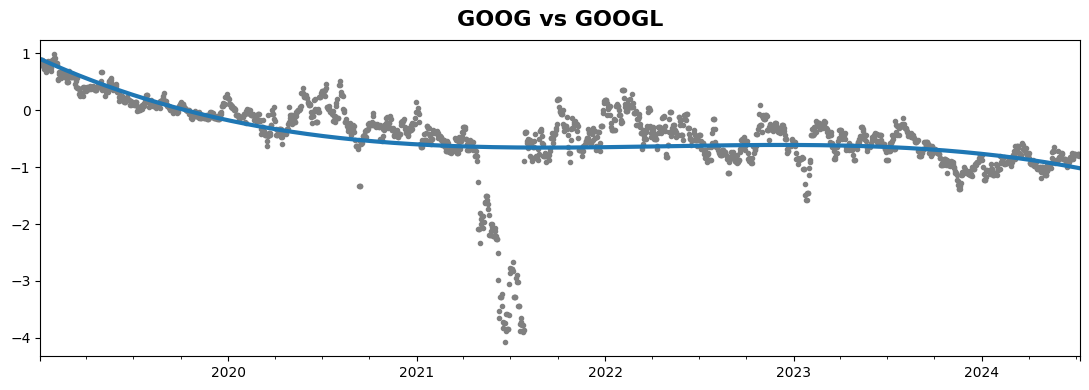

In [5]:
dp = DeterministicProcess(
    index=df.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=3,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()
y = df['Percent premium for votes']  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(style=".", color="0.5", title=f"{TICKER_PAIRS[CHOSEN_TICKER][1]} vs {TICKER_PAIRS[CHOSEN_TICKER][0]}")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")


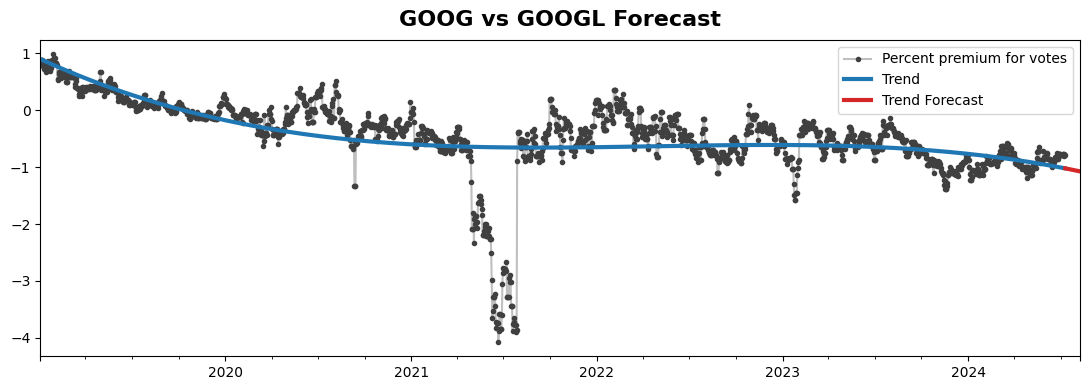

In [6]:
X = dp.out_of_sample(steps=30)
y_fore = pd.Series(model.predict(X), index=X.index)
ax = y["2019-01":].plot(title=f"{TICKER_PAIRS[CHOSEN_TICKER][1]} vs {TICKER_PAIRS[CHOSEN_TICKER][0]} Forecast", **plot_params)

ax = y_pred["2019-01":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

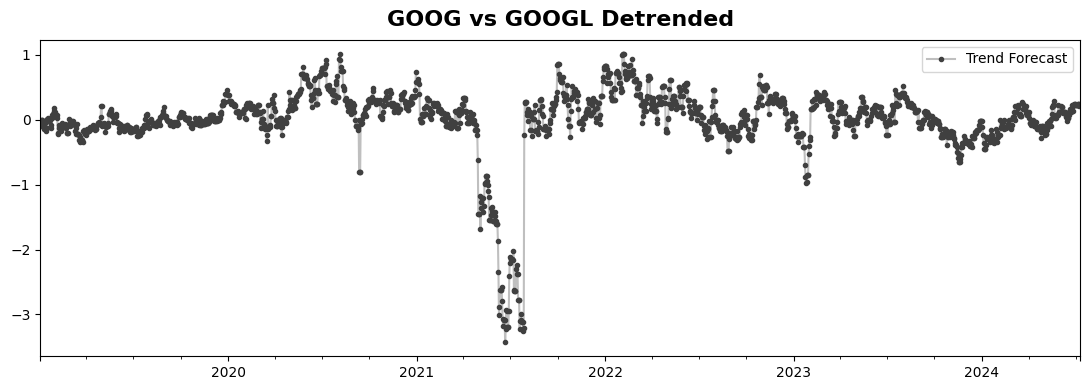

In [7]:
detrended = y - y_pred 
df['detrended premium'] = detrended
ax = detrended["2019-01":].plot(title=f"{TICKER_PAIRS[CHOSEN_TICKER][1]} vs {TICKER_PAIRS[CHOSEN_TICKER][0]} Detrended", **plot_params,label="Trend Forecast")
_ = ax.legend()

## Extracting seasonality 

In [8]:
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [9]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.set_xlim(1, 104)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

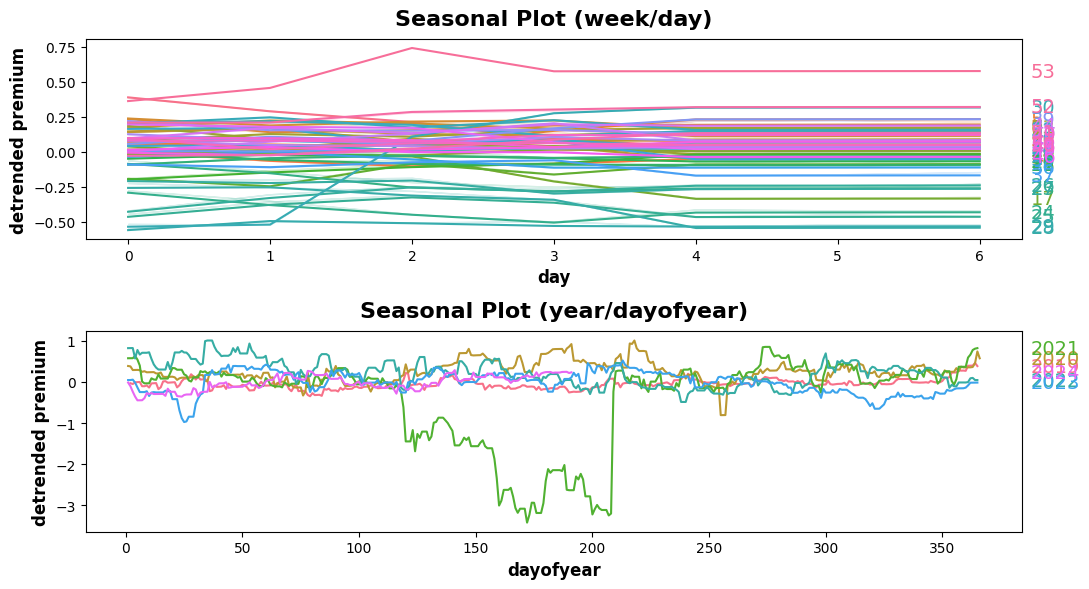

In [10]:
X = df.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.to_series().apply(lambda x: x.isocalendar()[1])  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y='detrended premium', period="week", freq="day", ax=ax0)
seasonal_plot(X, y='detrended premium', period="year", freq="dayofyear", ax=ax1);

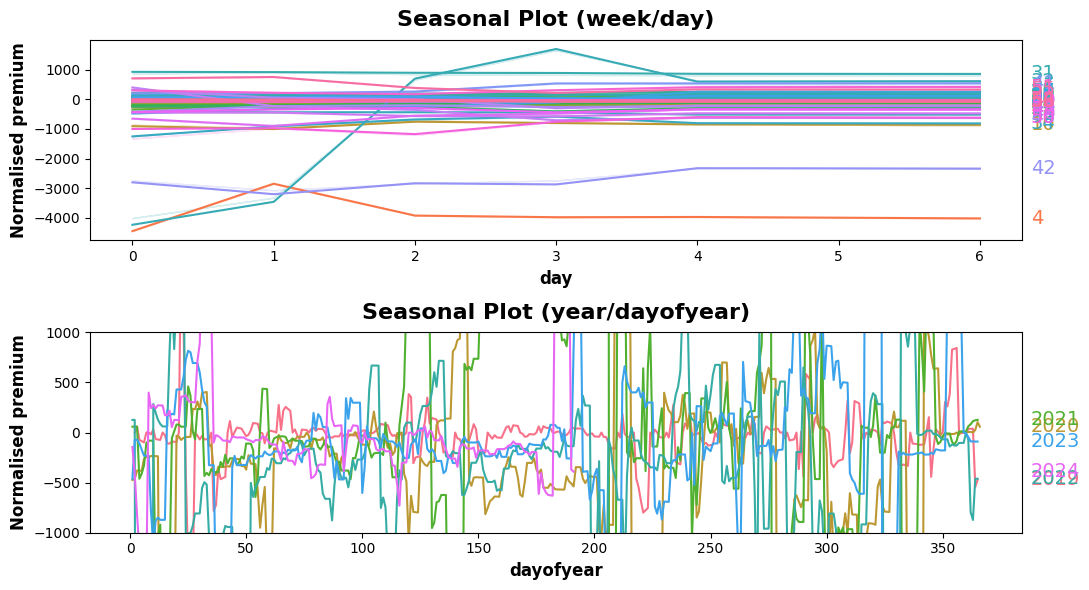

In [11]:
X = df.copy()

# Extracting day of the week and week number using isocalendar()
X["day"] = X.index.dayofweek
X["week"] = X.index.to_series().apply(lambda x: x.isocalendar()[1] + x.isocalendar()[0] - 2019)  # Extract week number using isocalendar

# Extracting day of the year and year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

# Normalize NumVehicles data within each week
X['Normalised premium'] = X.groupby('week')['detrended premium'].transform(lambda x: (x - x.iloc[0]) / x.iloc[0] * 100)

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
# Example usage of seasonal_plot with normalized data
seasonal_plot(X, y='Normalised premium', period='week', freq='day', ax=ax0)
#ax0.set_ylim(-1000, 100)  # Set y-limits based on the data in ax0

seasonal_plot(X, y='Normalised premium', period="year", freq='dayofyear', ax=ax1)
plt.ylim(-1000, 1000)
plt.tight_layout()
plt.show()


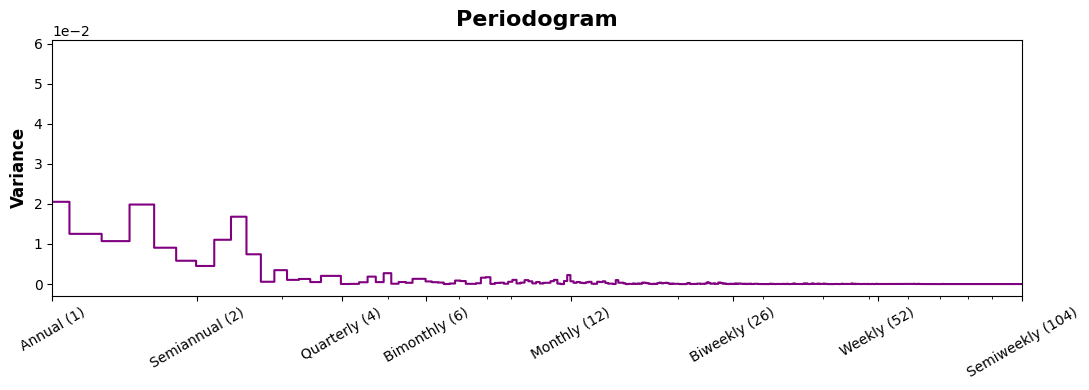

In [12]:
plot_periodogram(df['Percent premium for votes']);